In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import warnings
import operator


from pandas.tools.plotting import scatter_matrix

%matplotlib inline

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
print(train.shape, train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB
(9557, 143) None


In [3]:
print(test.shape, test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23856 entries, 0 to 23855
Columns: 142 entries, Id to agesq
dtypes: float64(8), int64(129), object(5)
memory usage: 25.8+ MB
(23856, 142) None


In [4]:
train.head(3)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.00,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.00,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.25,64.0,121.0,8464,4


In [5]:
test.head(2)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681


In [6]:
train.isnull().sum().sort_values(0, ascending= False).head(10)

rez_esc           7928
v18q1             7342
v2a1              6860
meaneduc             5
SQBmeaned            5
techozinc            0
techoentrepiso       0
techocane            0
techootro            0
cielorazo            0
dtype: int64

In [7]:
train['Target'].isnull().sum()

0

In [8]:
target = train['Target']
target.value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

In [9]:
#a discussion on kaggle indicates that you can replace an outlier with the value 5 
test.loc[test['rez_esc'] == 99.0 , 'rez_esc'] = 5

In [21]:
# a discussion in kaggle suggested inconsistencies between households poverty levels (ie: certain people had higher/lower pov level than other
# people in the household). This was resolved where the true target was parentescol1 == 1. I searched around for what other people did to solve
# this problem. The following code is borrowed from this kernel https://www.kaggle.com/bparesh/costa-rican-household-poverty-eda-basic-model
train_problem = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
error_households = train_problem[train_problem != True]

for household_id in error_households:
    target = train[(train['idhogar'] == household_id) & (train['parentesco1'] == 1)]['Target']
    train.loc[train['idhogar'] == household_id, 'Target'] = target

Text(0.5,1,'Training Set Poverty Indicator Count')

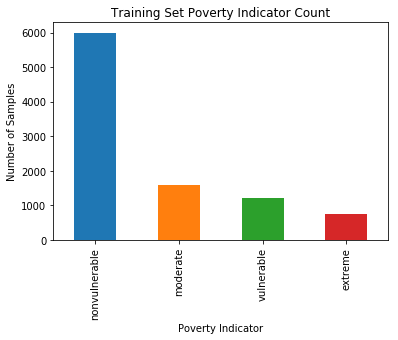

In [36]:
poverty_dict = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'nonvulnerable'})


poverty_level_count = train["Target"].value_counts()
poverty_level_count.plot.bar()

plt.xlabel('Poverty Indicator') 
plt.ylabel('Number of Samples'); 
plt.xticks([0, 1, 2, 3],["nonvulnerable", "moderate", "vulnerable", "extreme"])
plt.title("Training Set Poverty Indicator Count")

In [41]:
#taking a look at the correlates for our target variable
corr = train.corr()
corr["Target"].sort_values(ascending = False).head()

Target         1.000000
meaneduc       0.335203
cielorazo      0.304421
escolari       0.302305
SQBescolari    0.296577
Name: Target, dtype: float64

In [102]:
train["target_labeled"] = train["Target"].apply(lambda x : poverty_dict[x])
train["v14a_labeled"] = train["v14a"].apply(lambda x : "Has_Toilet" if x == 1 else "No_toilet")

In [103]:
toilet_group = train.groupby("target_labeled")["v14a_labeled"].value_counts()


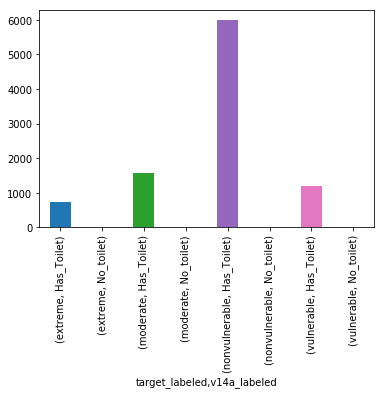

In [105]:
toilet_group.plot.bar()

In [106]:
colmap = sns.light_palette("blue", as_cmap=True)
pd.crosstab(train["target_labeled"], train["v14a_labeled"]).style.background_gradient(cmap = colmap)

v14a_labeled,Has_Toilet,No_toilet
target_labeled,,
extreme,746,9
moderate,1576,21
nonvulnerable,5986,10
vulnerable,1199,10


In [108]:
train["cieling_labeled"] = train["cielorazo"].apply(lambda x: "has_ceiling" if x == 1 else "no_ceiling")
colmap1 = sns.light_palette("red", as_cmap = True)
pd.crosstab(train["target_labeled"], train["cieling_labeled"]).style.background_gradient(cmap = colmap1)

cieling_labeled,has_ceiling,no_ceiling
target_labeled,,
extreme,318,437
moderate,757,840
nonvulnerable,4723,1273
vulnerable,676,533


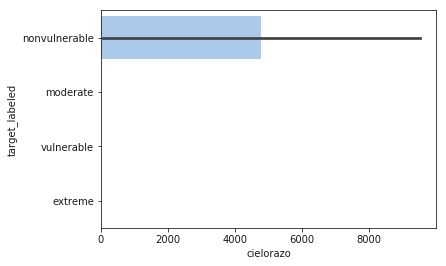

In [116]:
sns.set_color_codes("pastel")
sns.barplot(x=train["v14a"].value_counts(), y = train["target_labeled"], 
            color="b")

sns.barplot(x=train["cielorazo"], y = train["target_labeled"],
           color = "red")


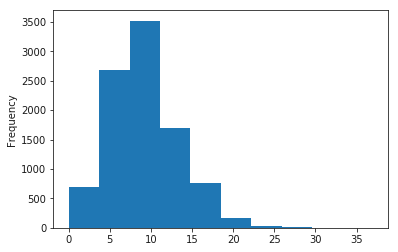

In [121]:
train["meaneduc"].plot.hist()